<a href="https://colab.research.google.com/github/TwistedAlex/TensorFlow2Practice/blob/main/TF_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Eager execution**
Evaluate operations immediately, without building graphs: operations *return concrete values* instead of constructing a compuational graph to run later. 
  *An intuitive interface*: Structure your code naturally and use Python data structures. Quickly iterate on small models and small data.
  *Easier debugging*: Call ops directly to inspect running models and test changes. Use standard Python debugging toools for immediate error report.
  *Natural control flow*: Use Python control flow instead of graph control flow, simplifying the specification of dynamic models.

**Setup and basic usage**

In [2]:
import os
import tensorflow as tf
import cProfile
tf.compat.v1.enable_eager_execution()

In [2]:
# Eager execution is enabled by default in TF2.0

tf.executing_eagerly()
# Run TF ops and the results will return immediately:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))
a = tf.constant([[1, 2], [3, 4]])
print(a)

hello, [[4.]]
tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


Broadcasting

In [3]:
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


Operator overloading

In [4]:
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


Use NumPy values

In [5]:
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


Obtain numpy value from a tensor:

In [7]:
print(a.numpy())

[[1 2]
 [3 4]]


**Dynamic control flow**

A major benefit of eager execution is that all the functionality of the host language is available while your model is executing. So, for example, it is easy to write fizzbuzz:

In [8]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

This has conditionals that depend on tensor values and it prints these values at runtime.

In [9]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


**Eager training**

Computing gradients

**Automatic differentiation** is useful for implementing machine learning algorithms such as backpropagation for training neural networks. During eager execution, use tf.GradientTape to trace operations for computing gradients later.

You can use [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to train and/or compute gradients in eager. It is especially useful for complicated training loops.


Args

persistent: Boolean controlling whether a persistent gradient tape is created. False by default, which means at most one call can be made to the gradient() method on this object.

watch_accessed_variables: Boolean controlling whether the tape will automatically watch any (trainable) variables accessed while the tape is active. Defaults to True meaning gradients can be requested from any result computed in the tape derived from reading a trainable Variable. If False users must explicitly watch any Variables they want to request gradients from.



**Train a model**

The following example creates a multi-layer model that classifies the standard MNIST handwritten digits. It demonstrates the optimizer and layer APIs to build trainable graphs in an eager execution environment.

In [3]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

Even without training, call the model and inspect the output in eager execution:

In [5]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.00620724  0.00718275  0.04194304  0.04503791  0.01508054 -0.00208858
   0.00349405  0.01988932 -0.01658518  0.02304578]]


While keras models have a builtin training loop (using the fit method), sometimes you need more customization. Here's an example, of a training loop implemented with eager:

In [6]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [8]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)

    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [9]:
def train(epochs):
  for epoch in range(epochs):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

In [10]:
train(epochs = 3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

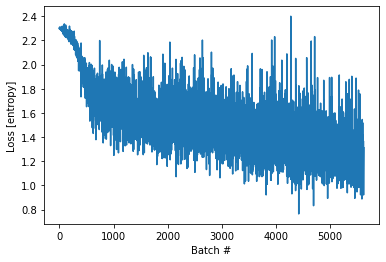

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

Disable eager execution

In [3]:
tf.compat.v1.disable_eager_execution()
a = tf.constant([[1, 2], [3, 4]])
print(a)

Tensor("Const:0", shape=(2, 2), dtype=int32)


In [4]:
b = tf.add(a, 1)
print(b)

Tensor("Add:0", shape=(2, 2), dtype=int32)


In [ ]:
import numpy as np

c = np.multiply(a, b)
print(c)